# Approach:2.2 - with R (using API)

In [18]:
# loading the necessary libraries for data manipulation, analysis and visualization 

library(httr)
library(jsonlite)
library(dplyr)
library(ggplot2)
library(ggExtra)
library(RColorBrewer)

######

In [19]:
# Setting the Spotify API credentials

client_id <- 'Enter_your_client_ID'
client_secret <- 'Enter_your_client_secret'


# Authenticate with the Spotify API

auth_response <- POST('https://accounts.spotify.com/api/token',
                      accept_json(),
                      authenticate(client_id, client_secret),
                      body = list(grant_type = 'client_credentials'),
                      encode = 'form',
                      verbose())
auth_token <- content(auth_response)$access_token

In [20]:
# Collecting Data from Spotify and Defining a function to get tracks' duration and genre from a given playlist

get_tracks_data <- function(playlist_id, token) {
  url <- paste0('https://api.spotify.com/v1/playlists/', playlist_id, '/tracks')
  response <- GET(url, add_headers(Authorization = paste('Bearer', token)))
  tracks <- content(response)$items
  
  track_list <- lapply(tracks, function(track) {
    list(
      song_duration = track$track$duration_ms / 1000,  # Convert to seconds
      song_genre = if (length(track$track$artists) > 0) track$track$artists[[1]]$name else 'Unknown'
    )
  })
  
  tracks_df <- bind_rows(track_list)
  return(tracks_df)
}

                       
# Playlist ID 
                       
playlist_id <- '37i9dQZF1DXcBWIGoYBM5M'
tracks_df <- get_tracks_data(playlist_id, auth_token)

######

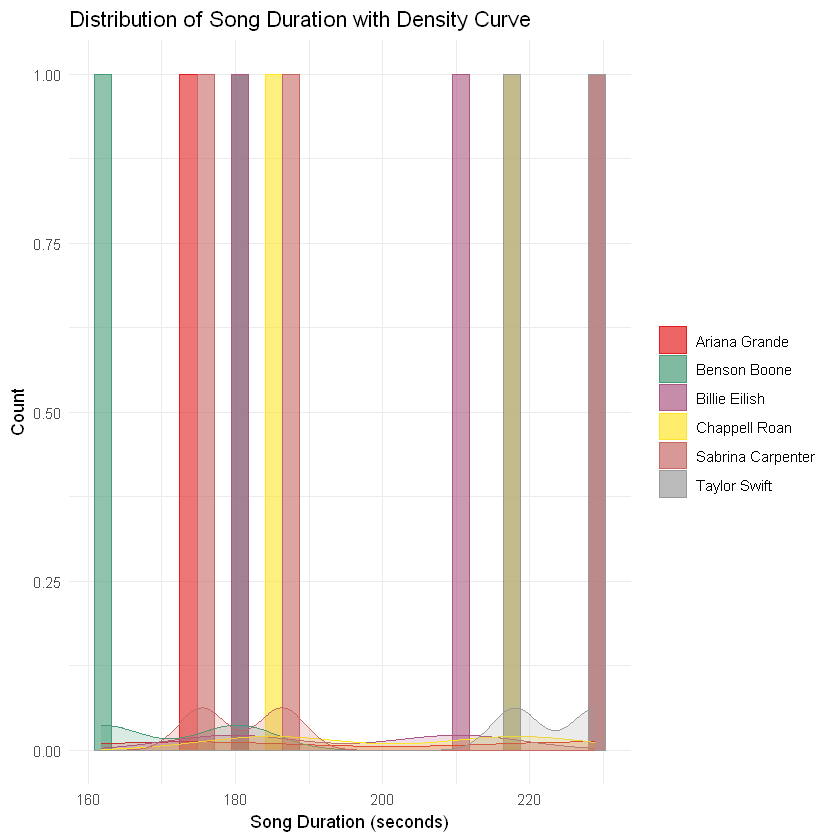

In [21]:
# Filtering out genres with fewer than 2 data points

filtered_tracks_df <- tracks_df %>%
  group_by(song_genre) %>%
  filter(n() > 1) %>%
  ungroup()


# Creating a color palette with enough distinct colors

num_genres <- n_distinct(filtered_tracks_df$song_genre)
palette <- colorRampPalette(brewer.pal(9, "Set1"))(num_genres)


# Creating the plot and Histogram with density plot 

ggplot(filtered_tracks_df, aes(x = song_duration, fill = song_genre, color = song_genre)) +
  geom_histogram(alpha = 0.6, position = 'identity', bins = 30) +
  geom_density(alpha = 0.2) +
  labs(
    title = 'Distribution of Song Duration with Density Curve',
    x = 'Song Duration (seconds)',
    y = 'Count'
  ) +
  theme_minimal() +
  theme(legend.title = element_blank()) +
  scale_fill_manual(values = palette) +
  scale_color_manual(values = palette)